# Tutorial 6: A Deep Dive into the ContinuousProcessor

Previous tutorials showed how to use `processor_type='continuous'` inside the `nmi.run()` function for automated processing. This notebook provides a more detailed look at what the `ContinuousProcessor` is actually doing under the hood.

**Goal:**
1.  Understand the expected data format `(n_channels, n_timepoints)`.
2.  Manually use the `ContinuousProcessor` to see how it transforms data.
3.  Show how this process relates to the simplified `nmi.run()` workflow.

## 1. Imports

In [1]:
import torch
import numpy as np
import neural_mi as nmi
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")

## 2. Generating Raw Time-Series Data

First, let's create a simple, raw time-series dataset. We'll make it shape `(n_timepoints, n_channels)` to simulate a common recording format.

In [7]:
n_timepoints = 1000
n_channels = 3

x_raw = np.random.randn(n_timepoints, n_channels)
y_raw = np.random.randn(n_timepoints, n_channels)

print(f"Raw data shape (timepoints, channels): {x_raw.shape}")

Raw data shape (timepoints, channels): (1000, 3)


## 3. Manual Processing

The `ContinuousProcessor` expects a 2D array of shape **`(n_channels, n_timepoints)`**. It then converts it into a 3D array of shape `(n_samples, n_channels, window_size)`.

In [8]:
# The processor expects shape (n_channels, n_timepoints), so we must transpose our raw data.
x_raw_transposed = x_raw.T
print(f"Transposed raw data shape: {x_raw_transposed.shape}\n")

# Initialize the processor
processor = nmi.data.ContinuousProcessor(window_size=10, step_size=1)

# Process the data
x_processed = processor.process(x_raw_transposed)

print(f"Processed data shape: {x_processed.shape}")

Transposed raw data shape: (3, 1000)

Processed data shape: torch.Size([991, 3, 10])


### Visualizing a Window

To make this more concrete, let's plot the raw data and highlight how a single processed sample (a window) is extracted from it. The plot below shows that `Window 4` from the processed data corresponds to the segment of raw data from timepoint 4 to 13.

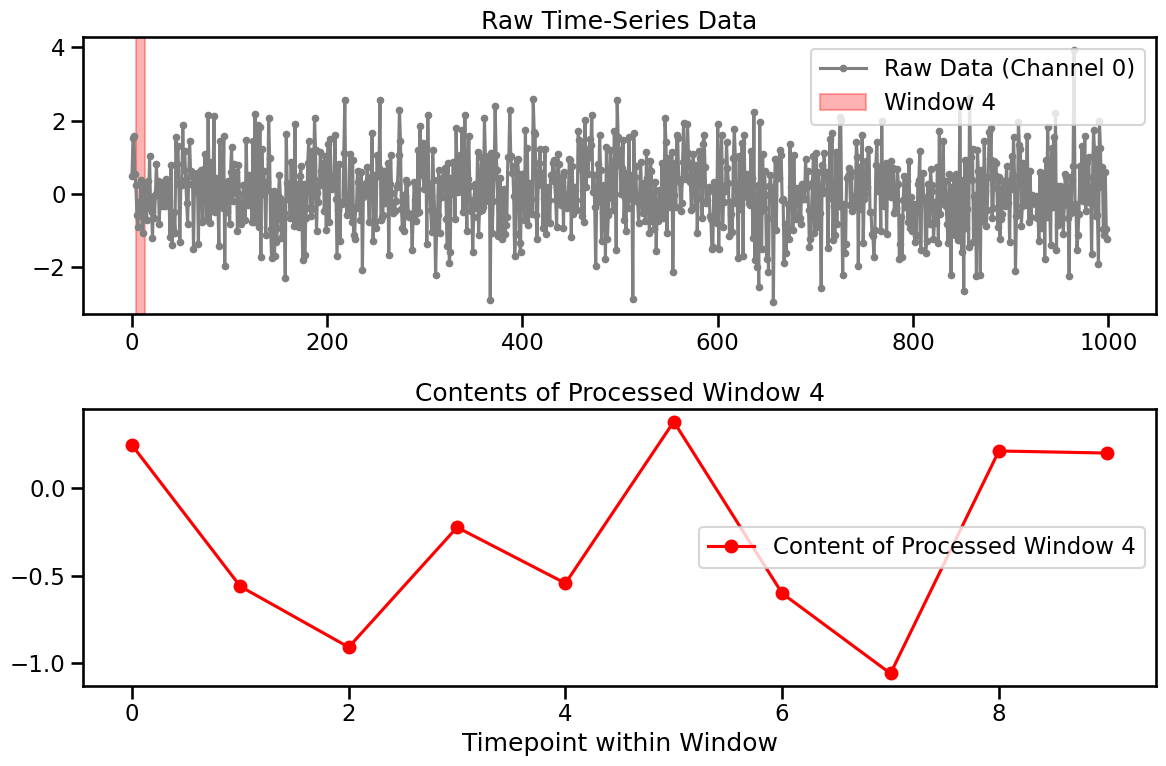

In [9]:
window_idx = 4
window_size = processor.window_size
step_size = processor.step_size

start_timepoint = window_idx * step_size
end_timepoint = start_timepoint + window_size

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

ax1.plot(x_raw[:, 0], label='Raw Data (Channel 0)', color='gray', marker='.')
ax1.set_title('Raw Time-Series Data')
ax1.axvspan(start_timepoint, end_timepoint - 1, color='red', alpha=0.3, label=f'Window {window_idx}')
ax1.legend()

ax2.plot(x_processed[window_idx, 0, :].numpy(), 'o-', color='red', label=f'Content of Processed Window {window_idx}')
ax2.set_title(f'Contents of Processed Window {window_idx}')
ax2.set_xlabel('Timepoint within Window')
ax2.legend()

plt.tight_layout()
plt.show()

## 4. The Simplified Workflow with `data_format`

Instead of manually transposing, you can simply tell the `run` function what format your data is in. Since our raw data has channels as the *last* dimension (`channels_last`), we can specify this in the `processor_params`. The `DataHandler` will then perform the transposition for us.

In [10]:
base_params = {
    'n_epochs': 100, 'learning_rate': 1e-3, 'batch_size': 32,
    'patience': 15, 'embedding_dim': 8, 'hidden_dim': 32, 'n_layers': 2
}

results = nmi.run(
    x_data=x_raw, # Pass the raw (timepoints, channels) data
    y_data=y_raw,
    mode='estimate',
    processor_type='continuous',
    processor_params={'window_size': 10, 'step_size': 1, 'data_format': 'channels_last'},
    base_params=base_params,
    random_seed=42,
    verbose=False
)

print(f"\nMI Estimate from automated pipeline: {results.mi_estimate:.3f} bits")

2025-10-04 19:44:33 - neural_mi - INFO - Starting parameter sweep with 12 workers...


Parameter Sweep Progress:   0%|          | 0/1 [00:00<?, ?task/s]

2025-10-04 19:44:38 - neural_mi - INFO - Parameter sweep finished.

MI Estimate from automated pipeline: 0.012 bits


### A Note on Negative MI

You may have noticed that the MI estimate was negative. This is not a bug! The estimators used in this library (like InfoNCE) provide a *lower bound* on the true mutual information. 

By definition, true MI must be >= 0. However, when the true MI is very low (or zero, as is the case for our random data), the estimator can sometimes produce small negative values due to statistical noise during training. 

**A negative MI estimate should always be interpreted as an MI of zero.** It is a sign that the model correctly found no discernible relationship between the variables. Try playing with the number of samples (try 100 vs 1000) and see the effect!